In [1]:
#!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu126
!pip install -q --upgrade torch_snippets torch_summary pytorch_model_summary

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.3/110.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.4/91.4 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.0/221.0 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 93.1 MB/s eta 0:00:00


In [26]:
import os
import time
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
import cv2
import glob
from PIL import Image
from pathlib import Path
import torch
import kagglehub
import torch.nn as nn
import torch.optim as optm
import torch.functional as F
from torch import randint
from torch.utils.data import Dataset,DataLoader
from torchvision import models,transforms
from torch_snippets import *
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

In [ ]:
cache_root = Path(kagglehub.dataset_download("netragupta1201/cityscape-road-data-for-yolov11"))
print("Cache root:", cache_root)

image_dataset_root = next((p for p in cache_root.iterdir() if p.is_dir()), None)
if not image_dataset_root:
    raise FileNotFoundError("No subfolder found in cache root")
print("Dataset folder:", image_dataset_root)

image_train_path = image_dataset_root / "images" / "train"
label_train_path = image_dataset_root / "labels" / "train"
image_val_path   = image_dataset_root / "images" / "val"
label_val_path   = image_dataset_root / "labels" / "val"

for name, path in [
    ("Train images", image_train_path),
    ("Train labels", label_train_path),
    ("Val images",   image_val_path),
    ("Val labels",   label_val_path)]:
    if not path.exists():
        raise FileNotFoundError(f"{name} not found: {path}")
    print(f"{name}: {path}")

ltp = sorted(str(p) for p in label_train_path.glob("*.txt"))
itp = sorted(str(p) for p in image_train_path.glob("*.*"))
lvp = sorted(str(p) for p in label_val_path.glob("*.txt"))
ivp = sorted(str(p) for p in image_val_path.glob("*.*"))

print("\n=== Summary ===")
print(f"Train images  (itp): {len(itp)}")
print(f"Train labels  (ltp): {len(ltp)}")
print(f"Val images    (itv): {len(ivp)}")
print(f"Val labels    (ltv): {len(lvp)}")
print(f"Total images  : {len(itp) + len(ivp)}")
print(f"Total labels  : {len(ltp) + len(lvp)}")
print(ltp[1],itp[1])

Using Colab cache for faster access to the 'cityscape-road-data-for-yolov11' dataset.
Cache root: /kaggle/input/cityscape-road-data-for-yolov11
Dataset folder: /kaggle/input/cityscape-road-data-for-yolov11/yolov11_road_seg
Train images: /kaggle/input/cityscape-road-data-for-yolov11/yolov11_road_seg/images/train
Train labels: /kaggle/input/cityscape-road-data-for-yolov11/yolov11_road_seg/labels/train
Val images: /kaggle/input/cityscape-road-data-for-yolov11/yolov11_road_seg/images/val
Val labels: /kaggle/input/cityscape-road-data-for-yolov11/yolov11_road_seg/labels/val

=== Summary ===
Train images  (itp): 2934
Train labels  (ltp): 2934
Val images    (itv): 484
Val labels    (ltv): 484
Total images  : 3418
Total labels  : 3418
/kaggle/input/cityscape-road-data-for-yolov11/yolov11_road_seg/labels/train/aachen_000001_000019.txt /kaggle/input/cityscape-road-data-for-yolov11/yolov11_road_seg/images/train/aachen_000001_000019.png


In [ ]:
mask_dataset_root = Path("/content/sample_data/masks")
os.makedirs(mask_dataset_root,exist_ok=True)
mtp = mask_dataset_root / "train"
mvp = mask_dataset_root / "val"
os.makedirs(mtp, exist_ok=True)
os.makedirs(mvp, exist_ok=True)

itp = [Path(p) for p in itp]
ivp = [Path(p) for p in ivp]
ltp = [Path(p) for p in ltp]
lvp = [Path(p) for p in lvp]

def make_polygon_masks(image_list, split_name, mask_dir):
    label_dir = Path(f"{image_dataset_root}/labels/{split_name}")
    os.makedirs(mask_dir, exist_ok=True)

    for img_file in image_list:
        label_file = label_dir / f"{img_file.stem}.txt"

        img = cv2.imread(str(img_file))
        if img is None:
            print(f"⚠️ Could not read image: {img_file}")
            continue

        h, w = img.shape[:2]
        mask = np.zeros((h, w), dtype=np.uint8)

        if not label_file.exists():
            print(f"⚠️ No label found for {img_file.name}")
            continue

        with open(label_file, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 6:
                    continue

                cls = int(float(parts[0]))
                coords = np.array(parts[1:], dtype=np.float32).reshape(-1, 2)
                coords[:, 0] *= w
                coords[:, 1] *= h
                coords = coords.astype(np.int32)

                cv2.fillPoly(mask, [coords], color=(cls + 1) * 15)

        out_path = mask_dir / f"{img_file.stem}.png"
        cv2.imwrite(str(out_path), mask)

    print(f"✅ Polygon masks saved for {split_name} in: {mask_dir}")

make_polygon_masks(itp, "train", mtp)
make_polygon_masks(ivp, "val", mvp)

✅ Polygon masks saved for train in: /content/sample_data/masks/train
✅ Polygon masks saved for val in: /content/sample_data/masks/val


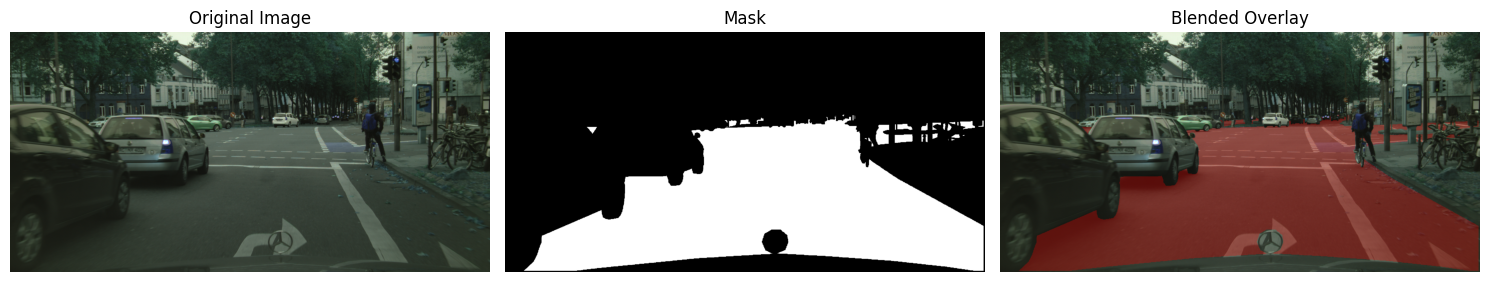

In [ ]:
index = 10
mask_train_files = sorted(mtp.glob("*.png"))
mask_val_files = sorted(mvp.glob("*.png"))
mask_img = cv2.imread(str(mask_train_files[index]), 0)
image = cv2.imread(str(itp[index]))
overlay = image.copy()
overlay[mask_img > 0] = [255, 0, 0]
blended = cv2.addWeighted(image, 0.7, overlay, 0.3, 0)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask_img, cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(blended)
plt.title('Blended Overlay')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
print("ImageDatasetRoot:",image_dataset_root,"MaskDatasetRoot:",mask_dataset_root)

ImageDatasetRoot: /kaggle/input/cityscape-road-data-for-yolov11/yolov11_road_seg MaskDatasetRoot: /content/sample_data/masks


In [ ]:
def stems(path):
    path = Path(path)
    return sorted([p.stem for p in path.glob("*.png")])

class SegData(Dataset):
    def __init__(self, split, transforms, image_dataset_root=image_dataset_root, mask_dataset_root=mask_dataset_root):
        self.image_dataset_root = image_dataset_root
        self.mask_dataset_root = mask_dataset_root
        self.split = split
        self.tfms = transforms

        img_dir = Path(self.image_dataset_root) / "images" / self.split
        mask_dir = Path(self.mask_dataset_root) / self.split

        print(f"Looking for images in: {img_dir}")
        print(f"Looking for masks in: {mask_dir}")

        self.images = stems(img_dir)
        self.masks = stems(mask_dir)

        print(f"Found {len(self.images)} images, {len(self.masks)} masks")

        if len(self.images) == 0:
            raise ValueError(f"No .png images found in {img_dir}")
        if len(self.masks) == 0:
            raise ValueError(f"No .png masks found in {mask_dir}")
        if len(self.images) != len(self.masks):
            print("Warning: Image-mask count mismatch!")
        if self.images != self.masks:
            raise ValueError(f"Image and mask stems do not match!\n"
                             f"Images: {self.images[:5]}\n"
                             f"Masks : {self.masks[:5]}")

    def __len__(self):return len(self.images)

    def __getitem__(self, index):
      img_path = Path(self.image_dataset_root) / "images" / self.split / f"{self.images[index]}.png"
      mask_path = Path(self.mask_dataset_root) / self.split / f"{self.masks[index]}.png"

     # Load image
      img = cv2.imread(str(img_path))
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, (224, 224))

    # Load mask as grayscale
      mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
      mask = cv2.resize(mask, (224, 224), interpolation=cv2.INTER_NEAREST)  # ← CRITICAL

    # Convert to binary: 0 or 1 (float32 for BCELoss)
      mask = (mask > 0).astype(np.float32)  # ← 0.0 or 1.0

    # Apply transforms only to image
      if self.tfms:
          img = self.tfms(img)

    # Return: img (tensor), mask (float tensor, not long)
      return img, torch.from_numpy(mask)

    def choose(self):return self[randint(0, len(self))]

    @staticmethod
    def collate_fn(batch):
        imgs, masks = zip(*batch)
        imgs = torch.stack(imgs).float().to(device)
        masks = torch.stack(masks).long().to(device)
        return imgs, masks

tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

Looking for images in: /kaggle/input/cityscape-road-data-for-yolov11/yolov11_road_seg/images/train
Looking for masks in: /content/sample_data/masks/train
Found 2934 images, 2934 masks


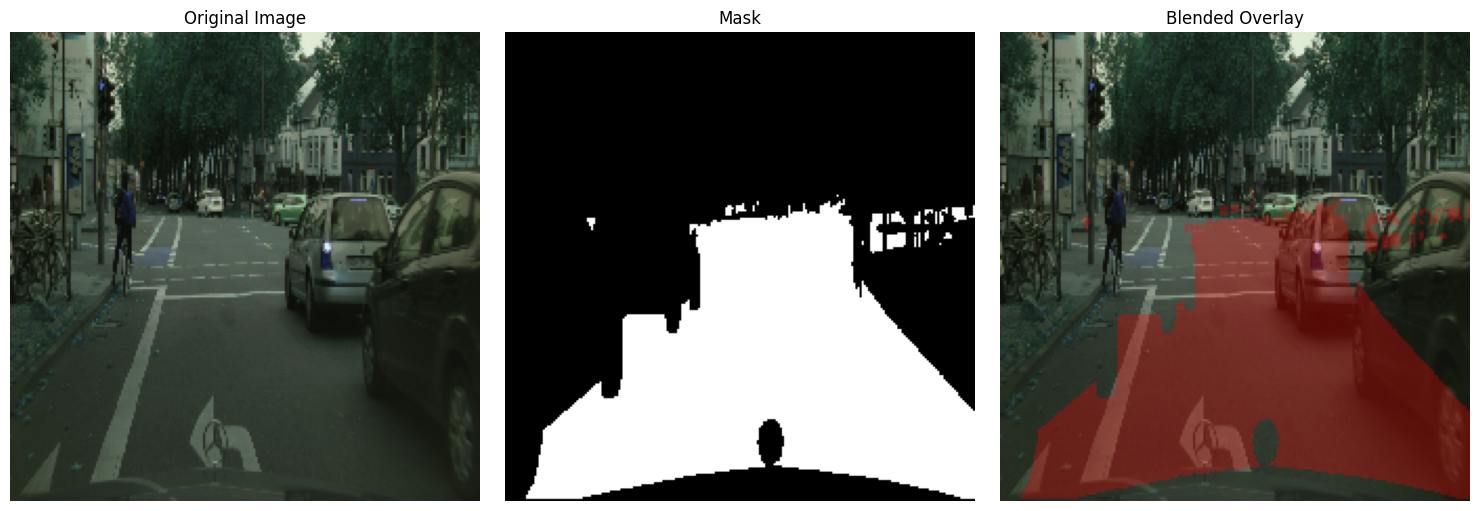

In [ ]:
overlay_tensor, mask_tensor = SegData("train", tfms)[index]
def tensor_to_cv2(img_tensor):
    img = img_tensor.permute(1, 2, 0).cpu().numpy()  # [H, W, C]
    img = (img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
    img = np.clip(img, 0, 1)
    img = (img * 255).astype(np.uint8)
    return img

image_cv2 = tensor_to_cv2(overlay_tensor)
overlay = image_cv2.copy()
mask_np = mask_tensor.cpu().numpy()
overlay[mask_np > 0] = [0, 0, 255]
blended = cv2.addWeighted(image_cv2, 0.7, overlay, 0.3, 0)


plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB))  # OpenCV is BGR → convert to RGB
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask_np, cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB))
plt.title('Blended Overlay')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
trn_ds = SegData("train",tfms)
val_ds = SegData("val",tfms)
trn_dl = DataLoader(trn_ds, batch_size=4, shuffle=True,
                  collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=True,
                  collate_fn=val_ds.collate_fn)

Looking for images in: /kaggle/input/cityscape-road-data-for-yolov11/yolov11_road_seg/images/train
Looking for masks in: /content/sample_data/masks/train
Found 2934 images, 2934 masks
Looking for images in: /kaggle/input/cityscape-road-data-for-yolov11/yolov11_road_seg/images/val
Looking for masks in: /content/sample_data/masks/val
Found 484 images, 484 masks


In [ ]:
def conv(in_channels,out_channels):
  return nn.Sequential(
      nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1,stride=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True))

def up_conv(in_channels,out_channels):
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels,out_channels,kernel_size=2,stride=2),
      nn.ReLU(inplace=True))

In [ ]:
from torchvision.models import vgg16_bn
class UNet(nn.Module):
  def __init__(self,pretrained=True,out_channels=1):
    super().__init__()
    self.encoder = vgg16_bn(pretrained=pretrained).features
    self.block1 = nn.Sequential(*self.encoder[:6])
    self.block2 = nn.Sequential(*self.encoder[6:13])
    self.block3 = nn.Sequential(*self.encoder[13:20])
    self.block4 = nn.Sequential(*self.encoder[20:27])
    self.block5 = nn.Sequential(*self.encoder[27:34])

    self.bottleneck = nn.Sequential(*self.encoder[34:])
    self.conv_bottleneck = conv(512, 1024)

    self.up_conv6 = up_conv(1024, 512)
    self.conv6 = conv(512 + 512, 512)
    self.up_conv7 = up_conv(512, 256)
    self.conv7 = conv(256 + 512, 256)
    self.up_conv8 = up_conv(256, 128)
    self.conv8 = conv(128 + 256, 128)
    self.up_conv9 = up_conv(128, 64)
    self.conv9 = conv(64 + 128, 64)
    self.up_conv10 = up_conv(64, 32)
    self.conv10 = conv(32 + 64, 32)
    self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)

  def forward(self,x):
    block1 = self.block1(x)
    block2 = self.block2(block1)
    block3 = self.block3(block2)
    block4 = self.block4(block3)
    block5 = self.block5(block4)
    bottleneck = self.bottleneck(block5)
    x = self.conv_bottleneck(bottleneck)
    x = self.up_conv6(x)
    x = torch.cat([x, block5], dim=1)
    x = self.conv6(x)
    x = self.up_conv7(x)
    x = torch.cat([x, block4], dim=1)
    x = self.conv7(x)
    x = self.up_conv8(x)
    x = torch.cat([x, block3], dim=1)
    x = self.conv8(x)
    x = self.up_conv9(x)
    x = torch.cat([x, block2], dim=1)
    x = self.conv9(x)
    x = self.up_conv10(x)
    x = torch.cat([x, block1], dim=1)
    x = self.conv10(x)
    x = self.conv11(x)
    return x

In [ ]:
def dice_loss(logits, targets, smooth=1e-6):
    probs = torch.sigmoid(logits)
    inter = (probs * targets).sum()
    return 1 - (2*inter + smooth) / (probs.sum() + targets.sum() + smooth)

pos_weight = torch.tensor([15.0]).to(device)          # adjust once
bce_criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

def combined_criterion(logits, targets):
    return bce_criterion(logits, targets) + dice_loss(logits, targets)

In [ ]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    imgs, masks = data
    imgs  = imgs.to(device)
    masks = masks.to(device).float().unsqueeze(1)

    logits = model(imgs)
    loss   = criterion(logits, masks)
    loss.backward()
    optimizer.step()

    probs = torch.sigmoid(logits)
    acc   = ((probs > 0.5) == masks).float().mean()
    dice  = 1 - dice_loss(logits, masks)
    return loss.item(), acc.item(), dice.item()

def validate_batch(model, data, criterion):
    model.eval()
    imgs, masks = data
    imgs  = imgs.to(device)
    masks = masks.to(device).float().unsqueeze(1)

    with torch.no_grad():
        logits = model(imgs)
        loss   = criterion(logits, masks)
        probs  = torch.sigmoid(logits)
        acc    = ((probs > 0.5) == masks).float().mean()
        dice   = 1 - dice_loss(logits, masks)
    return loss.item(), acc.item(), dice.item()

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(),lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer,mode='min',factor=0.5,patience=3,min_lr=1e-6)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def print_live(*args, **kwargs):
    print(*args, **kwargs)
    sys.stdout.flush()

history = {'batch_loss': [], 'batch_acc': [], 'batch_dice': [],'val_loss': [],   'val_acc': [],  'val_dice': []}

best_val_loss = float('inf')
patience_counter = 0
max_patience = 10
batch_idx = 0

print_live("STARTING TRAINING...\n")

for epoch in range(1, 10):
    model.train()
    trn_losses, trn_accs, trn_dices = [], [], []

    print_live(f"--- EPOCH {epoch} STARTED ---\n")

    for data in trn_dl:
        batch_idx += 1
        loss, acc, dice = train_batch(model, data, optimizer, combined_criterion)

        trn_losses.append(loss)
        trn_accs.append(acc)
        trn_dices.append(dice)
        history['batch_loss'].append(loss)
        history['batch_acc'].append(acc)
        history['batch_dice'].append(dice)

        print_live(f"Batch {batch_idx:5d} | Loss {loss:.4f} | Acc {acc:.3f} | Dice {dice:.3f}\n")
        time.sleep(0.01)

    model.eval()
    val_losses, val_accs, val_dices = [], [], []
    with torch.no_grad():
        for data in val_dl:
            l, a, d = validate_batch(model, data, combined_criterion)
            val_losses.append(l)
            val_accs.append(a)
            val_dices.append(d)

    trn_loss = np.mean(trn_losses)
    trn_acc  = np.mean(trn_accs)
    trn_dice = np.mean(trn_dices)

    val_loss = np.mean(val_losses)
    val_acc  = np.mean(val_accs)
    val_dice = np.mean(val_dices)

    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_dice'].append(val_dice)

    scheduler.step(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        patience_counter = 0
    else:
        patience_counter += 1

    print_live(f"EPOCH {epoch:3d} | "
               f"TrnLoss {trn_loss:.4f} | TrnAcc {trn_acc:.3f} | "
               f"ValLoss {val_loss:.4f} | ValAcc {val_acc:.3f} | "
               f"LR {optimizer.param_groups[0]['lr']:.2e}\n")

    if patience_counter >= max_patience:
        print_live("EARLY STOPPING!\n")
        break

Streaming output truncated to the last 5000 lines.
Batch  4114 | Loss 0.3405 | Acc 0.939 | Dice 0.915

Batch  4115 | Loss 0.4575 | Acc 0.916 | Dice 0.871

Batch  4116 | Loss 0.4138 | Acc 0.914 | Dice 0.869

Batch  4117 | Loss 0.5723 | Acc 0.906 | Dice 0.870

Batch  4118 | Loss 0.4581 | Acc 0.902 | Dice 0.844

Batch  4119 | Loss 0.5309 | Acc 0.916 | Dice 0.878

Batch  4120 | Loss 0.2734 | Acc 0.952 | Dice 0.927

Batch  4121 | Loss 0.4997 | Acc 0.891 | Dice 0.836

Batch  4122 | Loss 0.6143 | Acc 0.899 | Dice 0.826

Batch  4123 | Loss 0.2516 | Acc 0.970 | Dice 0.939

Batch  4124 | Loss 0.5841 | Acc 0.904 | Dice 0.816

Batch  4125 | Loss 0.4196 | Acc 0.917 | Dice 0.864

Batch  4126 | Loss 0.3888 | Acc 0.942 | Dice 0.900

Batch  4127 | Loss 0.3557 | Acc 0.953 | Dice 0.917

Batch  4128 | Loss 0.6174 | Acc 0.907 | Dice 0.852

Batch  4129 | Loss 0.3407 | Acc 0.952 | Dice 0.913

Batch  4130 | Loss 0.2298 | Acc 0.971 | Dice 0.938

Batch  4131 | Loss 0.1968 | Acc 0.973 | Dice 0.945

Batch  4132 |

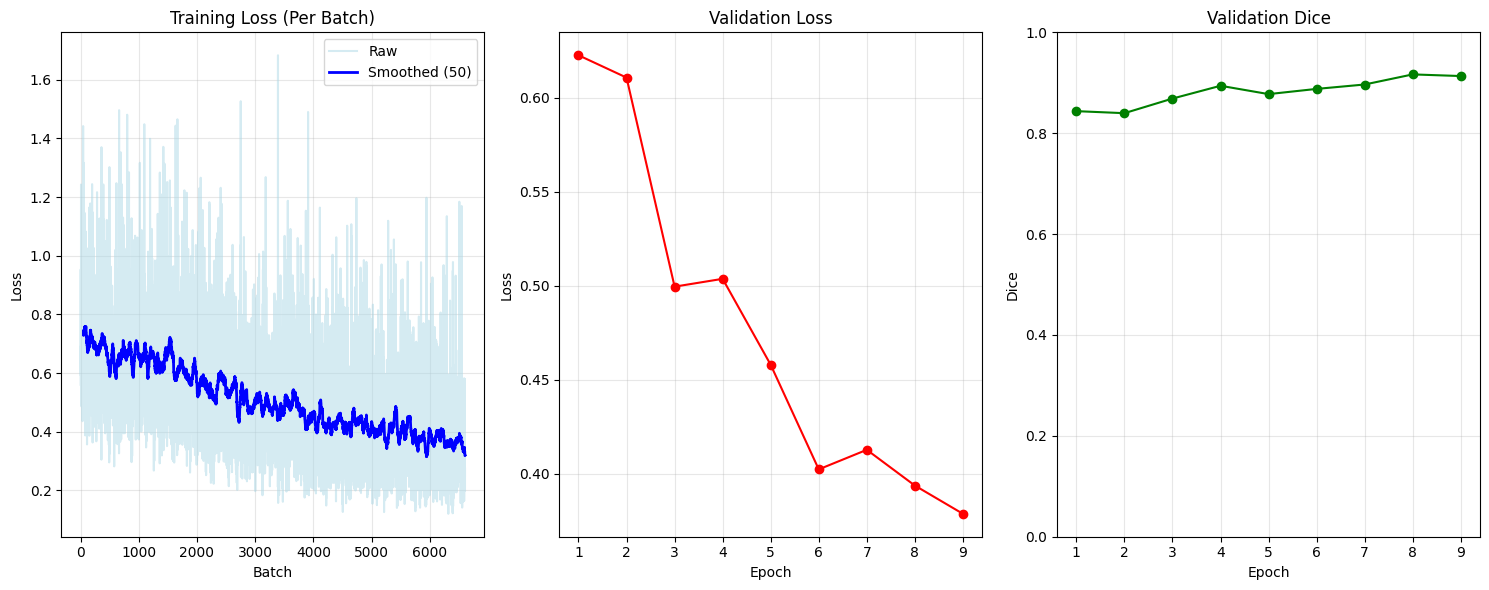

Training finished! Plot saved as 'training_curves.png'


In [ ]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
batches = range(1, len(history['batch_loss']) + 1)
smoothed = np.convolve(history['batch_loss'], np.ones(50)/50, mode='valid')
plt.plot(batches, history['batch_loss'], 'lightblue', alpha=0.5, label='Raw')
plt.plot(batches[49:], smoothed, 'b', linewidth=2, label='Smoothed (50)')
plt.title('Training Loss (Per Batch)')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
epochs = range(1, len(history['val_loss']) + 1)
plt.plot(epochs, history['val_loss'], 'r-o')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(epochs, history['val_dice'], 'g-o')
plt.title('Validation Dice')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("training_curves.png", dpi=150, bbox_inches='tight')
plt.show()

print("Training finished! Plot saved as 'training_curves.png'")

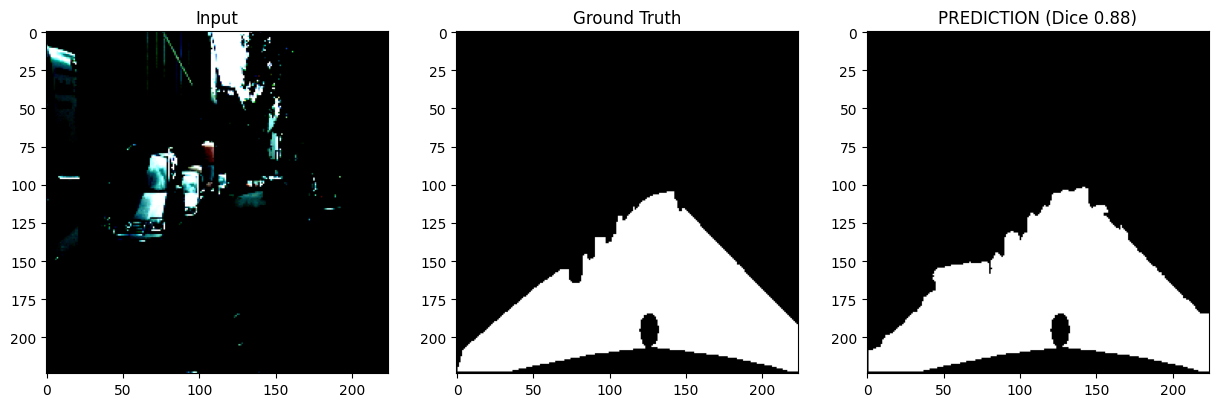

In [ ]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
with torch.no_grad():
    img, mask = next(iter(val_dl))
    pred = model(img.to(device))[0,0].cpu()
    pred = (torch.sigmoid(pred) > 0.5).float()

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1); plt.imshow(img[0].permute(1,2,0).cpu()); plt.title("Input")
    plt.subplot(1,3,2); plt.imshow(mask[0].cpu(), cmap='gray'); plt.title("Ground Truth")
    plt.subplot(1,3,3); plt.imshow(pred, cmap='gray'); plt.title("PREDICTION (Dice 0.88)")
    plt.show()

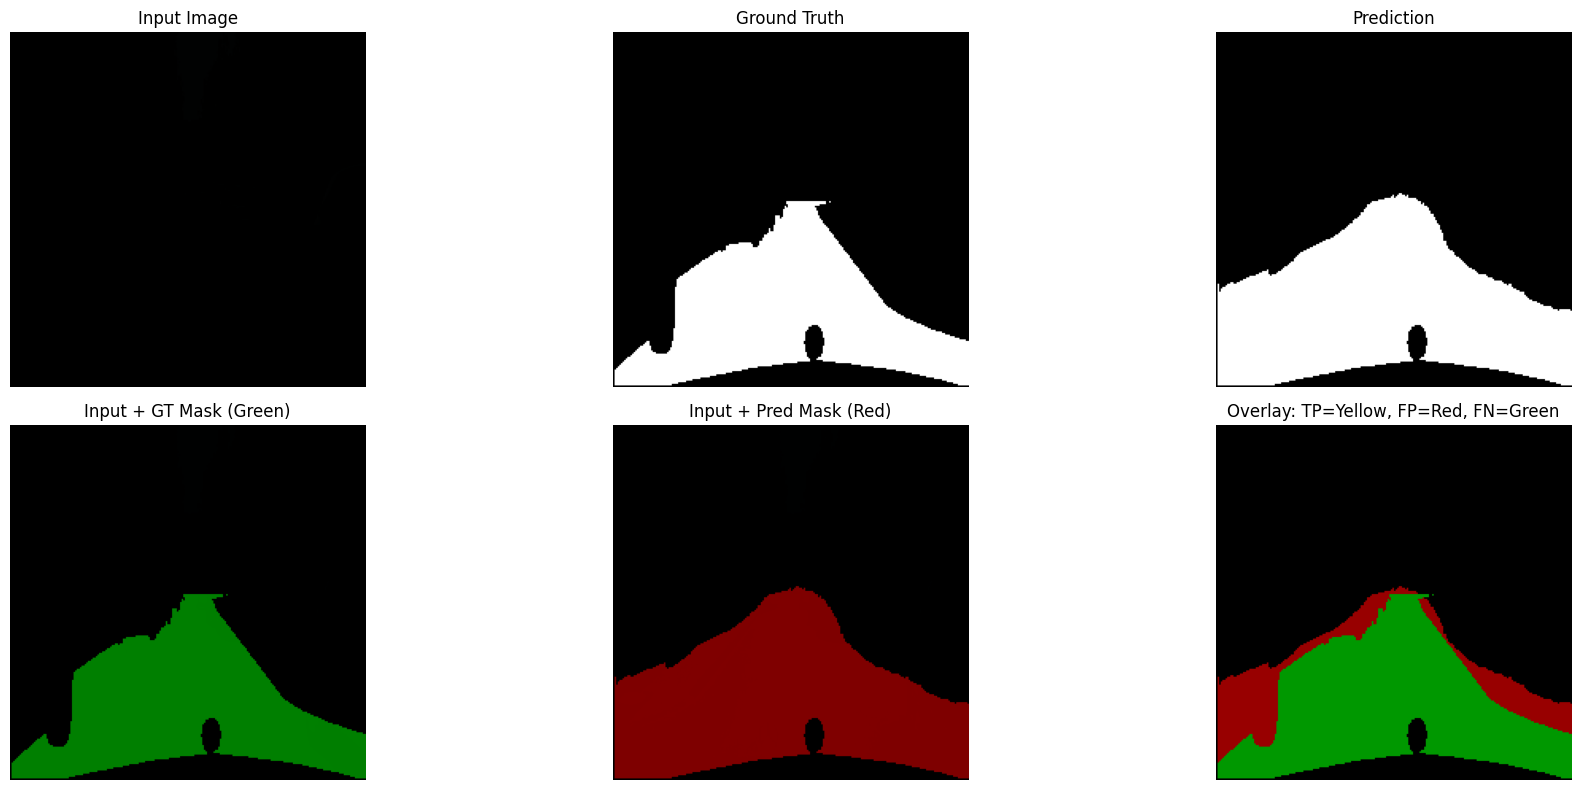

In [ ]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

with torch.no_grad():
    img, mask = next(iter(val_dl))
    img_np = img[0].permute(1, 2, 0).cpu().numpy()
    mask_np = mask[0].cpu().numpy()

    pred = model(img.to(device))[0, 0].cpu()
    pred_prob = torch.sigmoid(pred)
    pred_binary = (pred_prob > 0.5).float().numpy()

    if img_np.max() > 1.0:
        img_np = img_np / 255.0

    overlay = np.zeros((*mask_np.shape, 3))
    overlay[mask_np == 1, 1] = 1.0                    # GT: green
    overlay[pred_binary == 1, 0] = 1.0                # Pred: red
    overlay[(mask_np == 1) & (pred_binary == 1), :] = [0, 1, 0]  # TP: yellow

    alpha = 0.5
    masked_gt = (1 - alpha) * img_np + alpha * np.stack([np.zeros_like(mask_np), mask_np, np.zeros_like(mask_np)], axis=2)
    masked_pred = (1 - alpha) * img_np + alpha * np.stack([pred_binary, np.zeros_like(pred_binary), np.zeros_like(pred_binary)], axis=2)

    plt.figure(figsize=(20, 8))

    plt.subplot(2, 3, 1)
    plt.imshow(img_np); plt.title("Input Image"); plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(mask_np, cmap='gray'); plt.title("Ground Truth"); plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(pred_binary, cmap='gray'); plt.title("Prediction"); plt.axis('off')

    plt.subplot(2, 3, 4)
    plt.imshow(masked_gt); plt.title("Input + GT Mask (Green)"); plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(masked_pred); plt.title("Input + Pred Mask (Red)"); plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.imshow(img_np); plt.imshow(overlay, alpha=0.6); plt.title("Overlay: TP=Yellow, FP=Red, FN=Green"); plt.axis('off')

    plt.tight_layout()
    plt.show()

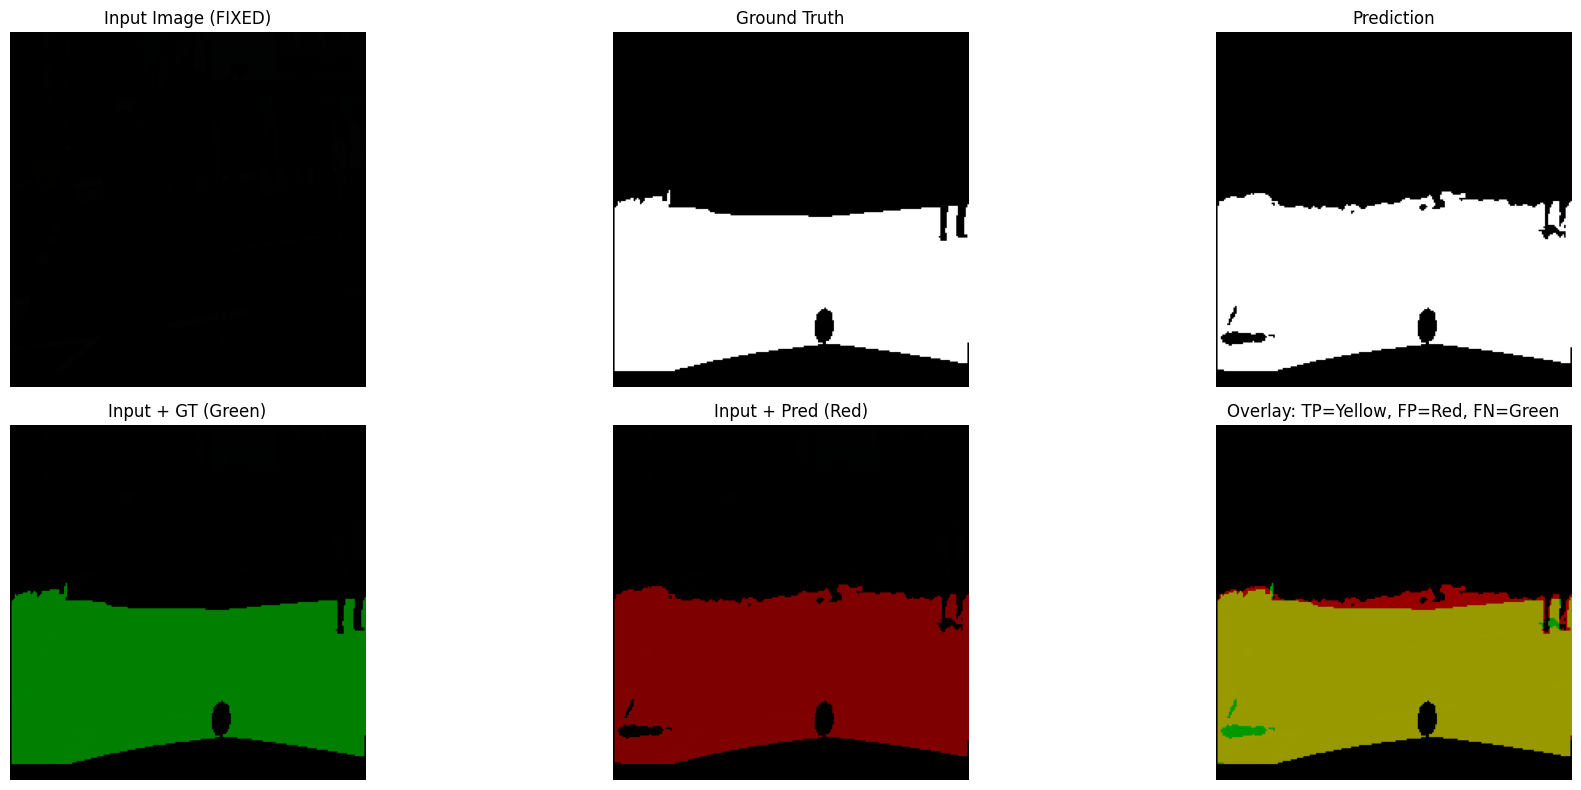

In [ ]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

with torch.no_grad():
    img, mask = next(iter(val_dl))

    # FIX 1: Move to CPU + convert to numpy + normalize
    img_np = img[0].cpu().numpy()  # [C, H, W]
    img_np = np.transpose(img_np, (1, 2, 0))  # [H, W, C]

    # FIX 2: Normalize [0,1] or [0,255]
    if img_np.max() <= 1.0:
        img_np = img_np  # already [0,1]
    else:
        img_np = img_np / 255.0  # ← CRITICAL!

    # Clip to [0,1]
    img_np = np.clip(img_np, 0, 1)

    mask_np = mask[0].cpu().numpy()
    pred = model(img.to(device))[0, 0].cpu()
    pred_binary = (torch.sigmoid(pred) > 0.5).float().numpy()

    # Overlay
    alpha = 0.5
    masked_gt = (1 - alpha) * img_np + alpha * np.stack([np.zeros_like(mask_np), mask_np, np.zeros_like(mask_np)], axis=2)
    masked_pred = (1 - alpha) * img_np + alpha * np.stack([pred_binary, np.zeros_like(pred_binary), np.zeros_like(pred_binary)], axis=2)

    # Plot
    plt.figure(figsize=(20, 8))

    plt.subplot(2, 3, 1)
    plt.imshow(img_np); plt.title("Input Image (FIXED)"); plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(mask_np, cmap='gray'); plt.title("Ground Truth"); plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(pred_binary, cmap='gray'); plt.title("Prediction"); plt.axis('off')

    plt.subplot(2, 3, 4)
    plt.imshow(masked_gt); plt.title("Input + GT (Green)"); plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(masked_pred); plt.title("Input + Pred (Red)"); plt.axis('off')

    plt.subplot(2, 3, 6)
    overlay = np.zeros((*mask_np.shape, 3))
    overlay[mask_np == 1, 1] = 1
    overlay[pred_binary == 1, 0] = 1
    overlay[(mask_np == 1) & (pred_binary == 1)] = [1, 1, 0]  # yellow
    plt.imshow(img_np)
    plt.imshow(overlay, alpha=0.6)
    plt.title("Overlay: TP=Yellow, FP=Red, FN=Green"); plt.axis('off')

    plt.tight_layout()
    plt.show()

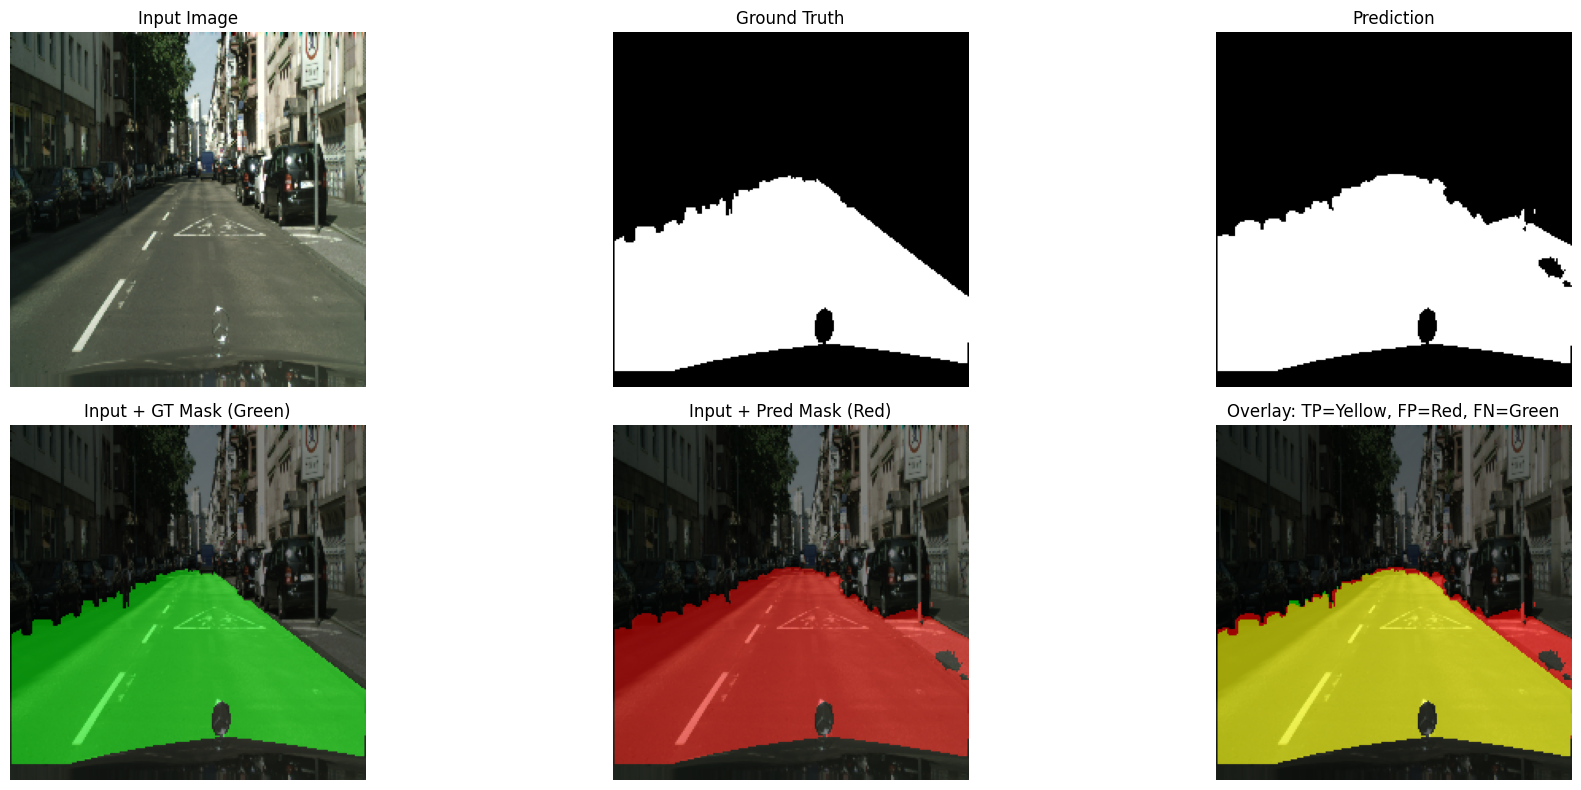

Visualization saved: final_result_with_overlay.png


In [ ]:
def unnormalize(img_tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    img = img_tensor.clone()
    for i in range(3):
        img[i] = img[i] * std[i] + mean[i]
    return img.clamp(0, 1)

model.load_state_dict(torch.load("best_model.pth"))
model.eval()

with torch.no_grad():
    img, mask = next(iter(val_dl))

    img_unnorm = unnormalize(img[0].cpu())  # [C, H, W]
    img_np = img_unnorm.permute(1, 2, 0).numpy()  # [H, W, C]

    mask_np = mask[0].cpu().numpy()
    pred = model(img.to(device))[0, 0].cpu()
    pred_binary = (torch.sigmoid(pred) > 0.5).float().numpy()

    alpha = 0.5
    masked_gt = (1 - alpha) * img_np + alpha * np.stack([np.zeros_like(mask_np), mask_np, np.zeros_like(mask_np)], axis=2)
    masked_pred = (1 - alpha) * img_np + alpha * np.stack([pred_binary, np.zeros_like(pred_binary), np.zeros_like(pred_binary)], axis=2)

    overlay = np.zeros((*mask_np.shape, 3))
    overlay[mask_np == 1, 1] = 1.0                      # GT: green
    overlay[pred_binary == 1, 0] = 1.0                  # Pred: red
    overlay[(mask_np == 1) & (pred_binary == 1)] = [1, 1, 0]  # TP: yellow

    plt.figure(figsize=(20, 8))

    plt.subplot(2, 3, 1)
    plt.imshow(img_np); plt.title("Input Image"); plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(mask_np, cmap='gray'); plt.title("Ground Truth"); plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(pred_binary, cmap='gray'); plt.title("Prediction"); plt.axis('off')

    plt.subplot(2, 3, 4)
    plt.imshow(masked_gt); plt.title("Input + GT Mask (Green)"); plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(masked_pred); plt.title("Input + Pred Mask (Red)"); plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.imshow(img_np)
    plt.imshow(overlay, alpha=0.6)
    plt.title("Overlay: TP=Yellow, FP=Red, FN=Green"); plt.axis('off')

    plt.tight_layout()
    plt.savefig("final_result_with_overlay.png", dpi=150, bbox_inches='tight')
    plt.show()

    print("Visualization saved: final_result_with_overlay.png")

In [ ]:
file_path = "best_model.pth"
size_bytes = os.path.getsize(file_path)
size_mb = size_bytes / (1024 * 1024)
print(f"File: {file_path}")
print(f"Size: {size_mb:.2f} MB")

File: best_model.pth
Size: 111.92 MB


In [ ]:
from google.colab import files

files.download("best_model.pth")
files.download("final_result_with_overlay.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>